In [3]:
#importing libraries
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib as mpl
from scipy.stats import multivariate_normal 
from random import random as rand
import psrf

In [5]:
# seed a random state
rng = np.random.RandomState(0)

In [6]:
#data
x = np.array([-0.86, -0.30, -0.05, 0.73])
n = np.array([5, 5, 5, 5])
y = np.array([0, 1, 3, 5])
A = np.linspace(-4, 4, 100)
B = np.linspace(-10, 30, 100)
ilogit_abx = 1 / (np.exp(-(A[:,None] + B[:,None,None] * x)) + 1)
likelihood = np.prod(ilogit_abx**y * (1 - ilogit_abx)**(n - y), axis=2)
#given from the data 
sig_A=2
sig_B=10
mu_A=0
mu_B=10
mean=[mu_A,mu_B]
correlation=0.5
# from wikipedia
cov_matrix=[[sig_A**2,correlation*sig_A*sig_B],
            [correlation*sig_A*sig_B,sig_B**2]]
prior=stats.multivariate_normal(mean,cov_matrix)

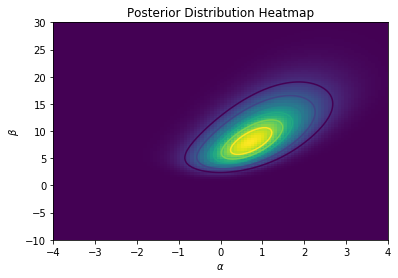

-100.12156562387516

In [9]:
#function defined in the exercise
def bioassaylp(a, b, x, y, n):
    """Log posterior density for the bioassay problem.

    Given a point(s) and the data, returns unnormalized log posterior density
    for the bioassay problem assuming uniform prior.

    Parameters
    ----------
    a, b : scalar or ndarray
        The point(s) (alpha, beta) in which the posterior is evaluated at.
        `a` and `b` must be of broadcastable shape.

    x, y, n : ndarray
        the data vectors

    Returns
    -------
    lp : scalar or ndarray
        the log posterior density at (a, b)

    """
    # last axis for the data points
    a = np.expand_dims(a, axis=-1)
    b = np.expand_dims(b, axis=-1)
    # these help using chain rule in derivation
    t = a + b*x
    et = np.exp(t)
    z = et/(1.+et)
    # negative log posterior (error function to be minimized)
    lp = np.sum(y*np.log(z)+ (n-y)*np.log(1.0-z), axis=-1)
    a_b=np.column_stack((a,b))
    log_post=prior.logpdf(a_b)
    lp=lp+log_post
    return lp


xv,yv = np.meshgrid(A,B)
pos = np.empty(xv.shape + (2,))
pos[:, :, 0] = xv; pos[:, :, 1] = yv


pos_arr = pos.reshape(100*100,2)
log_posterior = (bioassaylp(pos_arr[:,0],pos_arr[:,1],x,y,n)).reshape(100,100)
posterior = np.exp(log_posterior)


plt.imshow(posterior,origin='lower', aspect='auto', extent=(A[0], A[-1], B[0], B[-1]))
plt.contour(A,B,posterior)
plt.xlabel(r'$\alpha$')
plt.ylabel(r'$\beta$')
plt.title('Posterior Distribution Heatmap')
plt.show()

bioassaylp(-4,-10,x,y,n)


In [18]:
# How many samples to ignore as burn in 
burn_in = 5000
# How many samples to generate
no_samples = 5000
#Metropolis ALgorithm
def metropolis(theta_0,target=bioassaylp,burn_in=burn_in,no_samples=no_samples):

    lim =no_samples+burn_in

    theta = np.zeros((lim,2))
    


    #Setting initial value to theta_0
    theta[0]=theta_0

    #Loop counter
    i=1

    #Covariance for the jump matrix
   #cov = [[1,0],[0,5]]

    #Metropilis Algorithm
    while i <lim:
        theta_temp = multivariate_normal(mean=theta[i-1],cov=cov).rvs(1)
        r = np.exp(target(theta_temp[0],theta_temp[1],x,y,n)-
                   target(theta[i-1][0],theta[i-1][1],x,y,n))
        prob = min(1,r)
        u = rand()

        # Accept theta_temp with probability prob
        if(u<=prob):
            theta[i]=theta_temp
        # Reject theta_temp with probability 1-prob
        else:
            theta[i]=theta[i-1]
        i+=1
    
    return theta
   

### Chains, Starting Point and other details
Number of Chains for simulation of Metropolis Algorithm is 4.Their details are:
1. Chain 1
   * Starting Point : $(\alpha,\beta) = (-10,14) $
   * Burn-in Length : 5000
   * Number of samples: 5000
   * Jumping Distribution: $J(\theta^*|\theta^{t-1}) \sim N\left(\mu = \theta^{t-1}, \Sigma =   \begin{bmatrix}
    1 & 0 \\
    0 & 5
  \end{bmatrix}\right)$
2. Chain 2
   * Starting Point : $(\alpha,\beta) = (4,30) $
   * Burn-in Length : 5000
   * Number of samples: 5000
   * Jumping Distribution: $J(\theta^*|\theta^{t-1}) \sim N\left(\mu = \theta^{t-1}, \Sigma =   \begin{bmatrix}
    1 & 0 \\
    0 & 5
  \end{bmatrix}\right)$
3. Chain 3
   * Starting Point : $(\alpha,\beta) = (-4,40) $
   * Burn-in Length : 5000
   * Number of samples: 5000
   * Jumping Distribution: $J(\theta^*|\theta^{t-1}) \sim N\left(\mu = \theta^{t-1}, \Sigma =   \begin{bmatrix}
    1 & 0 \\
    0 & 5
  \end{bmatrix}\right)$
4. Chain 4
   * Starting Point : $(\alpha,\beta) = (1,50) $
   * Burn-in Length : 5000
   * Number of samples: 5000
   * Jumping Distribution: $J(\theta^*|\theta^{t-1}) \sim N\left(\mu = \theta^{t-1}, \Sigma =   \begin{bmatrix}
    1 & 0 \\
    0 & 5
  \end{bmatrix}\right)$

In [22]:
chains = []
starting_points = [[-10,14],[4,30],[-4,40],[1,50]]
#To remove the burn-in points for R_Hat calculations
for theta_0 in starting_points:
    chains.append(metropolis(theta_0=theta_0)[burn_in:])

D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in log
D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in multiply


In [23]:
#R_Hat values do not include Burn-in
#R_Hat single values for both Alpha and Beta
R = psrf.psrf(chains)
print("R-hat value of aplha:{0}".format(R[0]))
print("R-hat value of beta :{0}".format(R[1]))

R-hat value of aplha:1.0036267732409094
R-hat value of beta :1.0079644202498605


### Conclusion for R_Hat Value
We can clearly see the R_Hat values are nearly 1, as we cannot simulate infinte number of samples for a chain, we can more confidently infer that our R_Hat value would tend to 1 as $n \rightarrow \infty $.
Also important is the jump distribution was adjusted till we get the closest value of R_Hat value to 1.

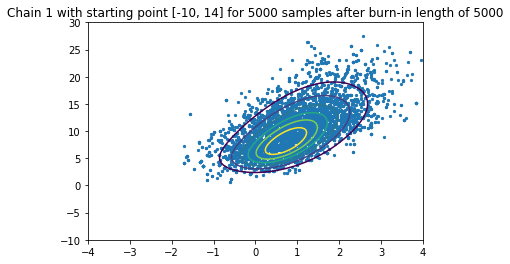

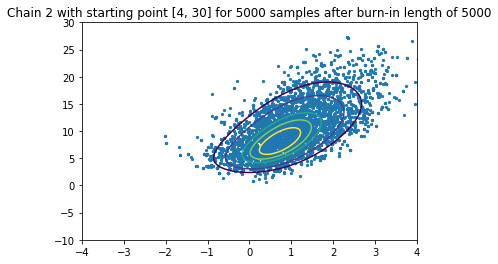

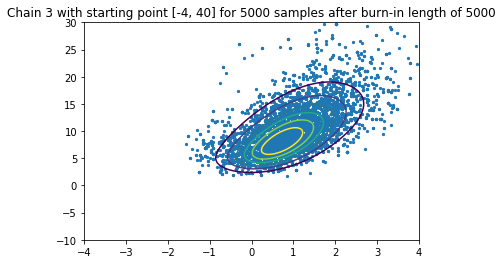

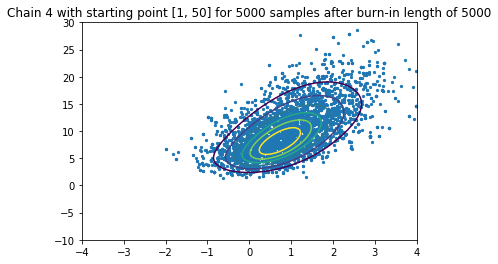

In [24]:
#Loop to generate all the graphs
for i in range(len(chains)):
    plt.scatter(chains[i][:,0],chains[i][:,1],5)
    plt.contour(A,B,posterior)
    plt.xlim([-4,4])
    plt.ylim([-10,30])
    plt.title
    ("Chain {0} with starting point [{1}, {2}] for {3} samples 
     "after burn-in length of {4}"
              .format(
        i+1,starting_points[i][0],starting_points[i][1],no_samples,burn_in))
    plt.show()